# Model Selection

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from category_encoders import CatBoostEncoder
from xgboost import XGBClassifier
import optuna
import warnings
import re

# Ignore warnings 

warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")
# Suppress Optuna's trial logs for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\Turanrh\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading and Initial Setup 

We start by loading the dataset.
the dataset is not shuffled, so we will shuffle it to ensure our training and test sets are representative of the
overall distribution. We also set the telephone_number as the index.

In [2]:
df_original = pd.read_parquet('multisim_dataset.parquet')

In [3]:
df = df_original.copy()

In [4]:
df.columns.to_list()

['telephone_number',
 'trf',
 'age',
 'gndr',
 'tenure',
 'age_dev',
 'dev_man',
 'device_os_name',
 'dev_num',
 'is_dualsim',
 'is_featurephone',
 'is_smartphone',
 'simcard_type',
 'region',
 'val2_1',
 'val3_1',
 'val4_1',
 'val5_1',
 'val6_1',
 'val7_1',
 'val8_1',
 'val9_1',
 'val10_1',
 'val11_1',
 'val12_1',
 'val13_1',
 'val14_1',
 'val15_1',
 'val16_1',
 'val17_1',
 'val18_1',
 'val19_1',
 'val20_1',
 'val21_1',
 'val2_2',
 'val3_2',
 'val4_2',
 'val5_2',
 'val6_2',
 'val7_2',
 'val8_2',
 'val9_2',
 'val10_2',
 'val11_2',
 'val12_2',
 'val13_2',
 'val14_2',
 'val15_2',
 'val16_2',
 'val17_2',
 'val18_2',
 'val19_2',
 'val20_2',
 'val21_2',
 'val2_3',
 'val3_3',
 'val4_3',
 'val5_3',
 'val6_3',
 'val7_3',
 'val8_3',
 'val9_3',
 'val10_3',
 'val11_3',
 'val12_3',
 'val13_3',
 'val14_3',
 'val15_3',
 'val16_3',
 'val17_3',
 'val18_3',
 'val19_3',
 'val20_3',
 'val21_3',
 'val2_4',
 'val4_4',
 'val5_4',
 'val6_4',
 'val7_4',
 'val8_4',
 'val9_4',
 'val10_4',
 'val11_4',
 'val12_4'

In [5]:
df.sample(frac=1, random_state=57)
df.set_index('telephone_number', inplace=True)

In [6]:
df.head()

,trf,age,gndr,tenure,age_dev,dev_man,device_os_name,dev_num,is_dualsim,is_featurephone,...,val13_6,val14_6,val15_6,val16_6,val17_6,val18_6,val19_6,val20_6,val21_6,target
telephone_number,,,,,,,,,,,,,,,,,,,,,
iWBn_13aJO,J,50,M,6957.0,1263,Samsung,Android OS,1,1,0,...,0.000000,0.0,0.00,0.56,0.00,0.00,60.0,7.0,0.0,1
8JWaD2wYoQ,M,52,M,1041.0,125,Samsung,Android OS,2,1,0,...,206.536585,0.0,0.40,0.00,0.16,0.24,156.0,0.0,2.0,1
sbPnQURi3j,A,49,U,7176.0,345,Samsung,Android OS,1,1,0,...,0.000000,0.0,0.25,2.35,0.00,0.25,241.0,87.0,4.0,1
qOy-JlqPTl,M,49,M,4309.0,466,Samsung,Android OS,1,1,0,...,51.885746,0.0,0.00,0.00,0.00,0.00,299.0,142.0,80.0,1
MNODhcb7h0,A,50,U,6999.0,695,Samsung,Android OS,1,1,0,...,0.000000,0.0,0.00,0.80,0.00,0.00,121.0,96.0,0.0,1


### EDA

In [7]:
miss = df.isna().sum()
miss_pct = miss/len(df)
miss_pct.sort_values(ascending=False).to_dict()

{'simcard_type': 0.0349,
 'val20_6': 0.0272,
 'val21_6': 0.0272,
 'val19_6': 0.0272,
 'val9_6': 0.0272,
 'val8_6': 0.0272,
 'val6_6': 0.0272,
 'val18_6': 0.0272,
 'val17_6': 0.0272,
 'val16_6': 0.0272,
 'val15_6': 0.0272,
 'val14_6': 0.0272,
 'val13_6': 0.0272,
 'val12_6': 0.0272,
 'val11_6': 0.0272,
 'val10_6': 0.0272,
 'val2_6': 0.0272,
 'val5_6': 0.0272,
 'val4_6': 0.0272,
 'val7_6': 0.0272,
 'val13_5': 0.0232,
 'val15_5': 0.0232,
 'val11_5': 0.0232,
 'val18_5': 0.0232,
 'val6_5': 0.0232,
 'val7_5': 0.0232,
 'val21_5': 0.0232,
 'val4_5': 0.0232,
 'val5_5': 0.0232,
 'val2_5': 0.0232,
 'val9_5': 0.0232,
 'val8_5': 0.0232,
 'val19_5': 0.0232,
 'val20_5': 0.0232,
 'val17_5': 0.0232,
 'val10_5': 0.0232,
 'val14_5': 0.0232,
 'val12_5': 0.0232,
 'val16_5': 0.0232,
 'val20_4': 0.021,
 'val5_4': 0.021,
 'val18_4': 0.021,
 'val21_4': 0.021,
 'val11_4': 0.021,
 'val4_4': 0.021,
 'val10_4': 0.021,
 'val9_4': 0.021,
 'val8_4': 0.021,
 'val7_4': 0.021,
 'val6_4': 0.021,
 'val19_4': 0.021,
 'val14

The overall missing values are manageable - no columns need to be dropped due to excessive missingness. 

All features can be retained for modeling with appropriate imputation strategies.

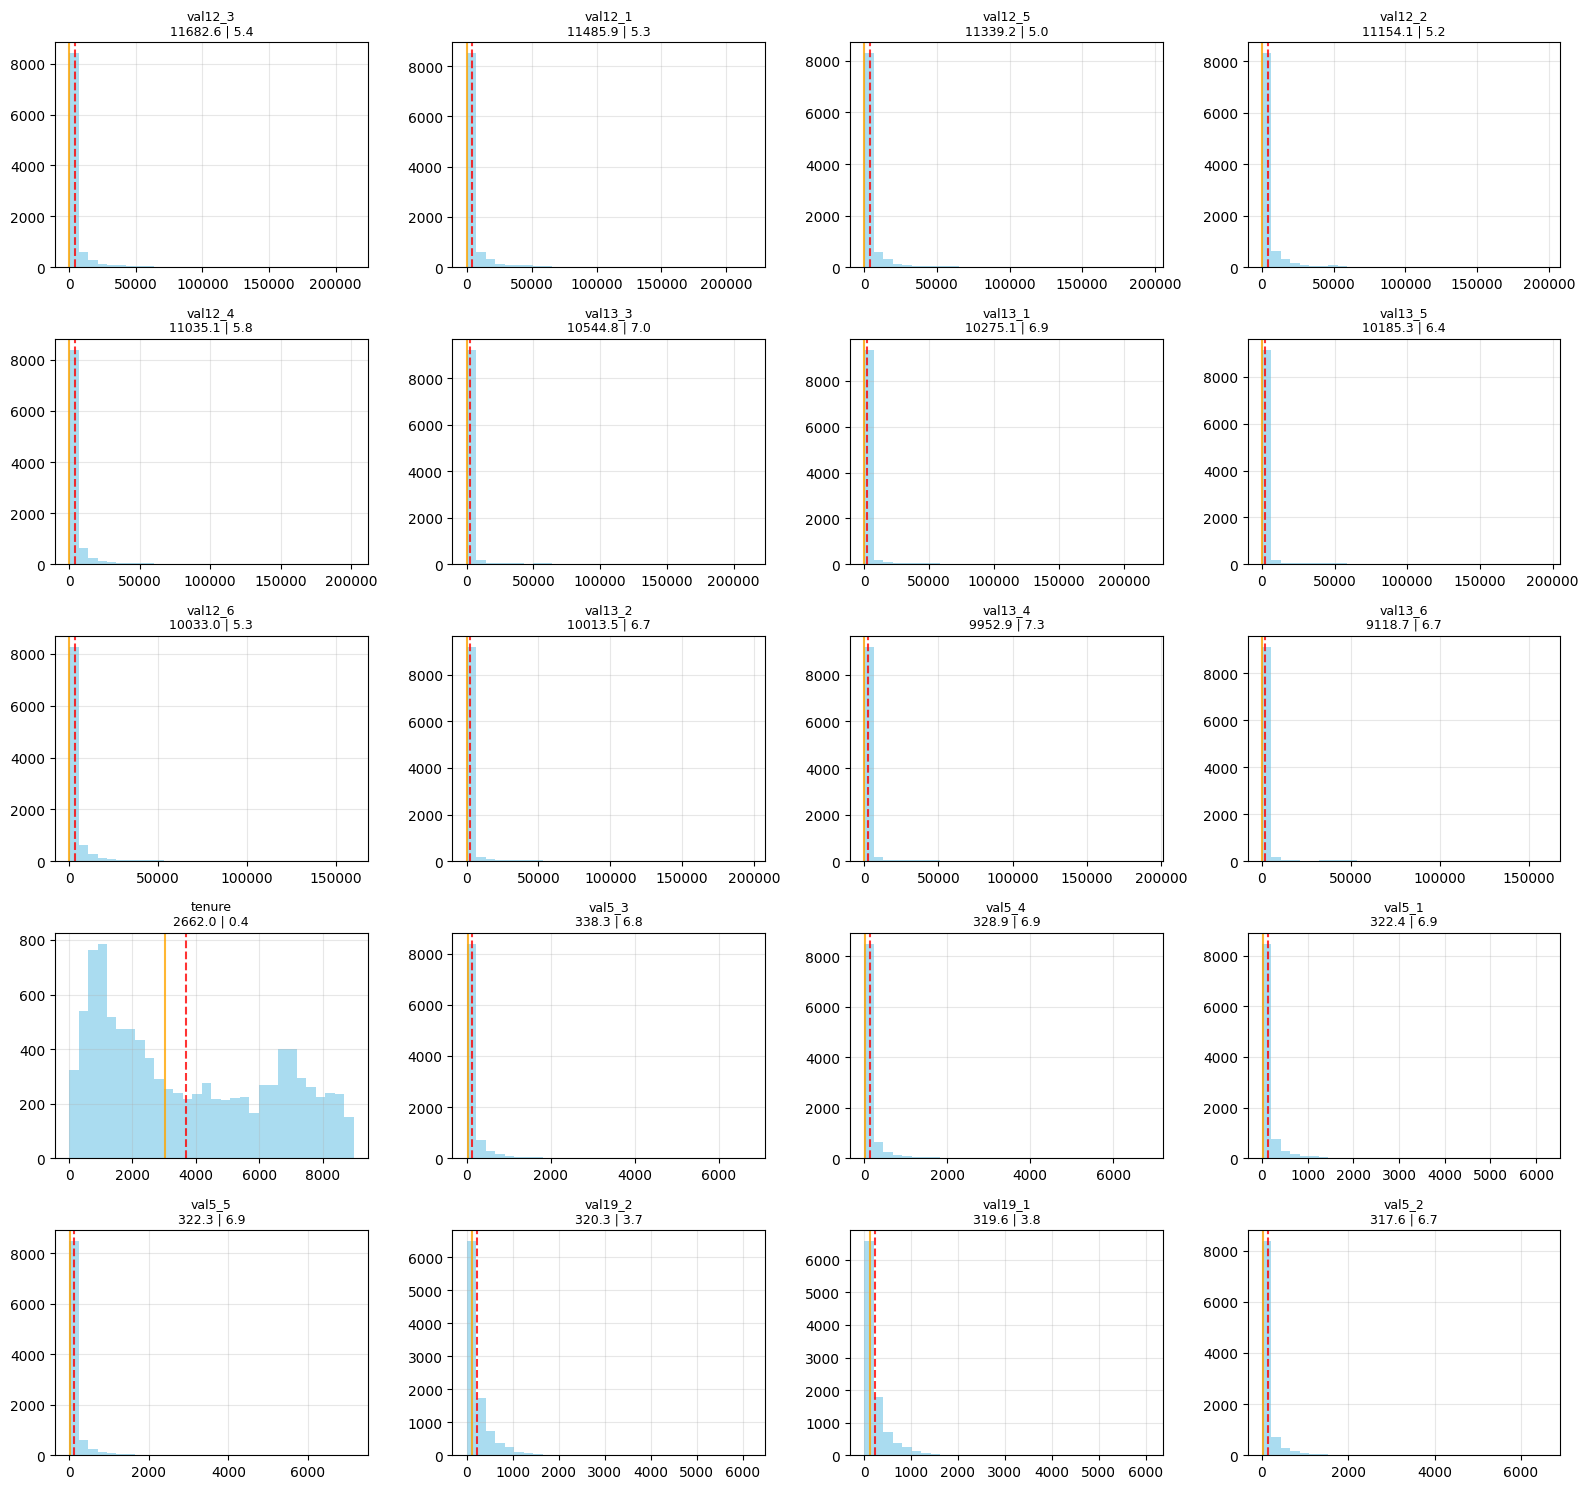

High skew features: 117
Top variance: val12_3


,mean,std,skew,missing_pct
val12_3,4231.459263,11682.592845,5.441322,1.8
val12_1,4345.885585,11485.861318,5.261394,0.0
val12_5,4142.563557,11339.153959,5.042994,2.3
val12_2,4194.912776,11154.144072,5.205529,1.6
val12_4,3929.210211,11035.112461,5.754903,2.1
val13_3,2396.325441,10544.846802,7.048250,1.8
val13_1,2450.204217,10275.093048,6.904071,0.0
val13_5,2391.526503,10185.337311,6.375367,2.3
val12_6,3504.610332,10033.040344,5.317799,2.7
val13_2,2364.732110,10013.496404,6.738901,1.6


In [8]:
numeric_df = df.select_dtypes(include=[np.number])
desc_stats = numeric_df.describe().T
desc_stats['skew'] = numeric_df.skew()
desc_stats['missing_pct'] = (numeric_df.isnull().sum() / len(numeric_df) * 100).round(1)
desc_stats = desc_stats.sort_values('std', ascending=False)

top_features = desc_stats.head(20).index.tolist()
ncols = 4
nrows = (len(top_features) + ncols - 1) // ncols

plt.figure(figsize=(16, 3 * nrows))
for i, col in enumerate(top_features):
    ax = plt.subplot(nrows, ncols, i + 1)
    data = numeric_df[col].dropna()
    
    ax.hist(data, bins=30, alpha=0.7, color='skyblue')
    ax.axvline(data.mean(), color='red', linestyle='--', alpha=0.8)
    ax.axvline(data.median(), color='orange', linestyle='-', alpha=0.8)
    
    ax.set_title(f'{col}\n{desc_stats.loc[col, "std"]:.1f} | {desc_stats.loc[col, "skew"]:.1f}', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

high_skew = len(desc_stats[abs(desc_stats['skew']) > 2])
print(f"High skew features: {high_skew}")
print(f"Top variance: {desc_stats.index[0]}")

desc_stats.head(10)[['mean', 'std', 'skew', 'missing_pct']]

Nearly all of them are skewed, with the exception of 'total_calls' and 'total_sms'.

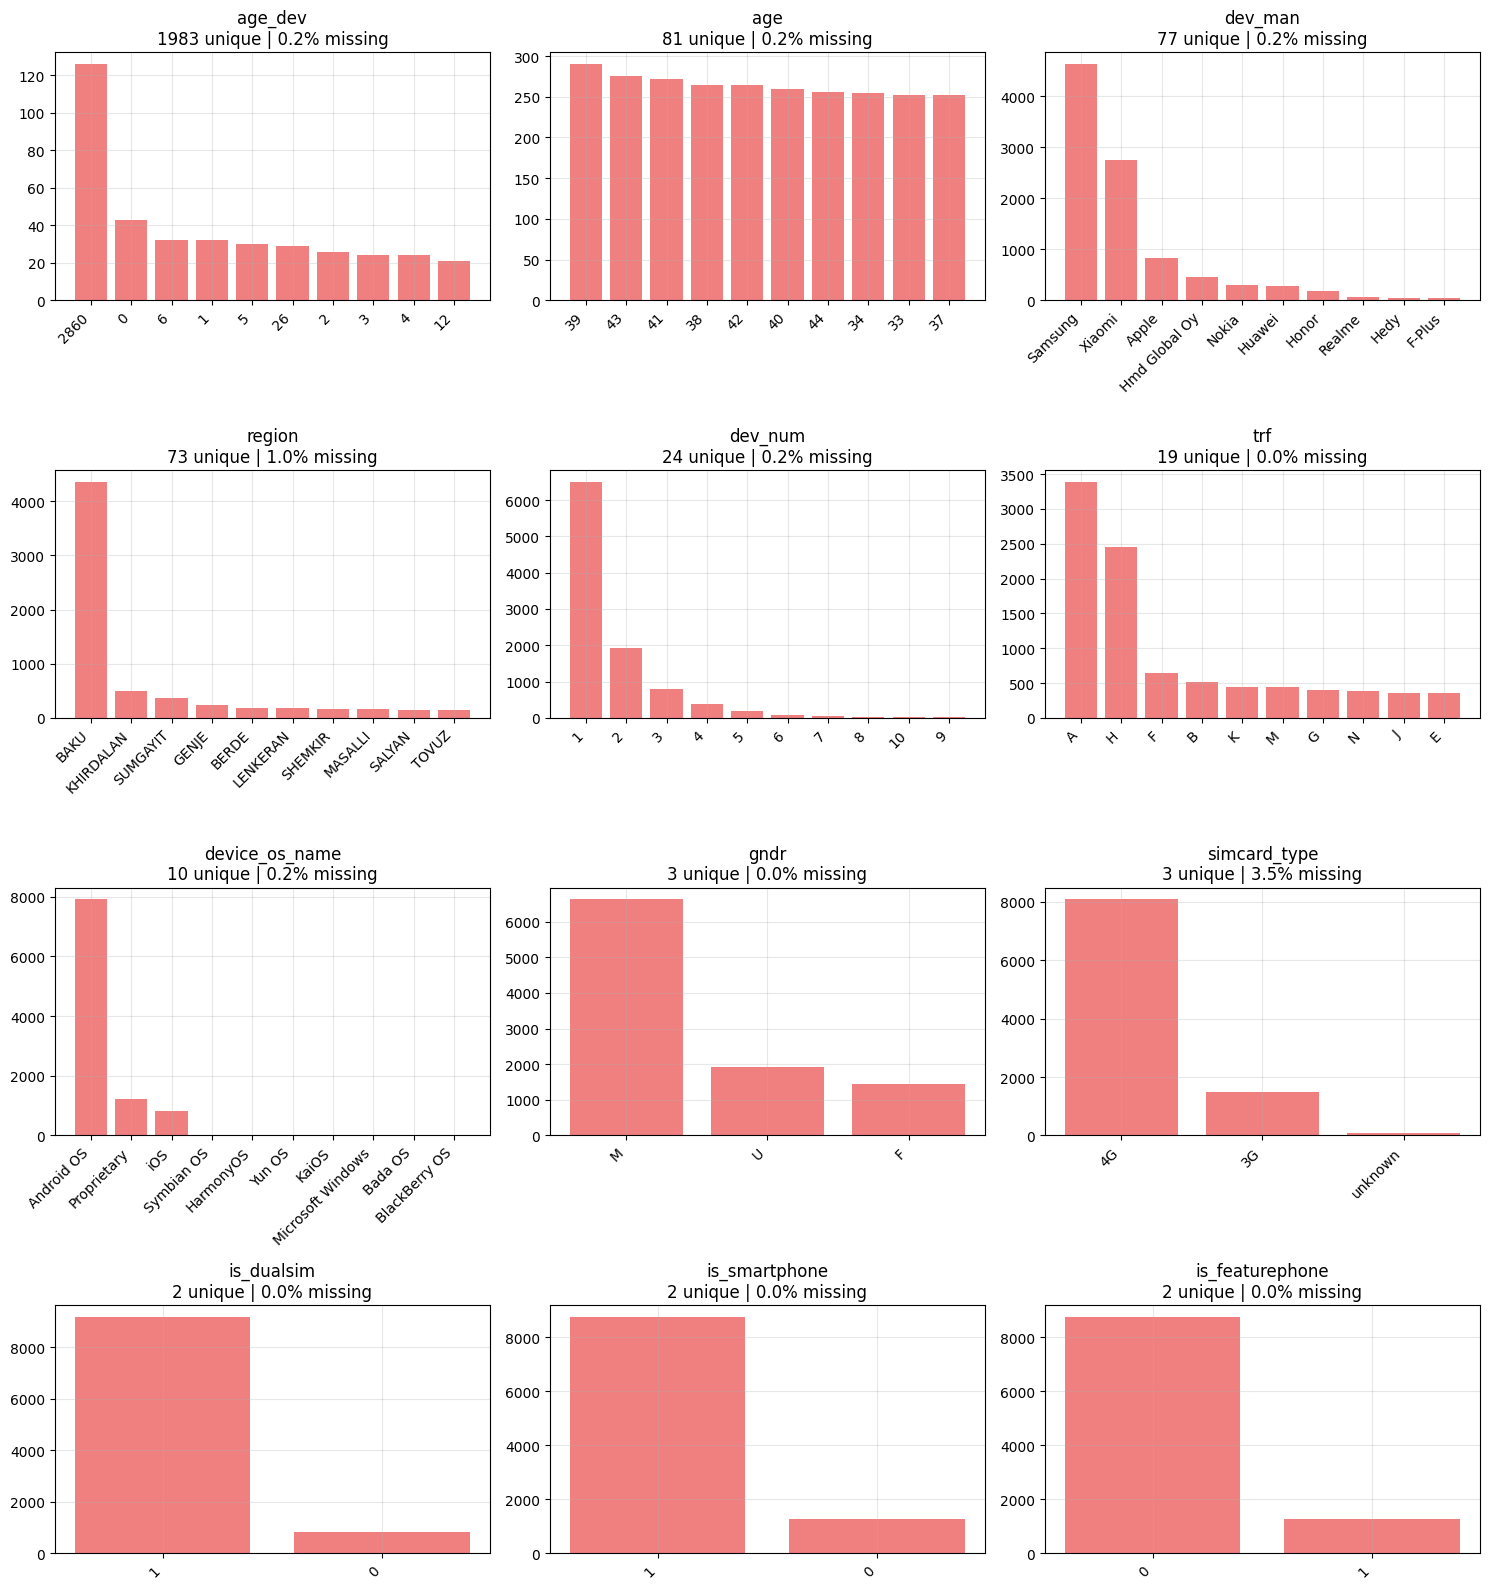

High cardinality features: 4


,unique_count,missing_pct,top_value,top_freq
age_dev,1983,0.2,2860,126
age,81,0.2,39,290
dev_man,77,0.2,Samsung,4623
region,73,1.0,BAKU,4360
dev_num,24,0.2,1,6501
trf,19,0.0,A,3390
device_os_name,10,0.2,Android OS,7910
gndr,3,0.0,M,6624
simcard_type,3,3.5,4G,8077
is_dualsim,2,0.0,1,9177


In [9]:
cat_df = df.select_dtypes(include=['object', 'category']) 
cat_summary = pd.DataFrame({
   'unique_count': cat_df.nunique(),
   'missing_pct': (cat_df.isnull().sum() / len(cat_df) * 100).round(1),
   'top_value': cat_df.mode().iloc[0] if len(cat_df) > 0 else None,
   'top_freq': [cat_df[col].value_counts().iloc[0] if len(cat_df[col].dropna()) > 0 else 0 for col in cat_df.columns]
}).sort_values('unique_count', ascending=False)

top_cats = cat_summary.head(12).index.tolist()
ncols = 3
nrows = (len(top_cats) + ncols - 1) // ncols

plt.figure(figsize=(15, 4 * nrows))
for i, col in enumerate(top_cats):
   ax = plt.subplot(nrows, ncols, i + 1)
   
   top_values = cat_df[col].value_counts().head(10)
   ax.bar(range(len(top_values)), top_values.values, color='lightcoral')
   ax.set_xticks(range(len(top_values)))
   ax.set_xticklabels(top_values.index, rotation=45, ha='right')
   ax.set_title(f'{col}\n{cat_summary.loc[col, "unique_count"]} unique | {cat_summary.loc[col, "missing_pct"]:.1f}% missing')
   ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

high_cardinality = len(cat_summary[cat_summary['unique_count'] > 30])
print(f"High cardinality features: {high_cardinality}")

cat_summary

'age' and 'age_dev' are saved as a categorical, we'll transform them later.

### Splitting Data and Identifying Column Types

In [10]:
target = 'target'
X = df.drop(columns=target)
y = df[target]

Next, we separate our features (X) from the target variable (y).
We then split the data into training and testing sets. Using `stratify=y`
ensures that the proportion of the target variable is the same in both
the train and test sets, which is crucial for classification tasks.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57, stratify=y)

In [12]:
def get_column_types(df):
    """Gets names of columns based on their types and naming patterns."""
    def val_pattern():
        arr=[]
        for second in range(1, 7):
            for first in range(2, 22):
                s=f"val{first}_{second}"
                if s not in df.columns:
                    continue
                arr.append(s)
        return arr

    numeric_cols = ['age', 'tenure', 'age_dev', 'dev_num']
    binary_cols = ['is_dualsim', 'is_featurephone', 'is_smartphone']
    categorical_cols = ['trf', 'gndr', 'dev_man', 'device_os_name', 'simcard_type', 'region']
    monthly_cols = val_pattern()
    
    return numeric_cols, binary_cols, categorical_cols, monthly_cols

We define a helper function to programmatically identify different groups of
columns (numeric, binary, categorical, and monthly) that will require
different preprocessing steps.

In [13]:
numeric_cols, binary_cols, categorical_cols, monthly_cols = get_column_types(X_train)
print("Column Types")
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Binary columns: {len(binary_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Monthly columns: {len(monthly_cols)}")

Column Types
Numeric columns: 4
Binary columns: 3
Categorical columns: 6
Monthly columns: 117


### Cell 4: Feature Engineering and Preprocessing


We'll use scikit-learn's Pipeline and ColumnTransformer to create a robust
preprocessing workflow. This involves creating custom transformers for
specific logic, such as handling outliers in the `age` column and
imputing missing values.

In [14]:
class NumericTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms numeric columns:
    1. Converts to numeric type.
    2. Clips 'age' to a reasonable range (18-80) to handle outliers.
    3. Imputes missing values with the median.
    """
    def __init__(self, age_clip_min=18, age_clip_max=80):
        self.age_clip_min = age_clip_min
        self.age_clip_max = age_clip_max
        self.medians = {}

    def fit(self, X, y=None):
        X_copy = X.copy()
        for col in X_copy.columns:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
            if col == 'age':
                X_copy[col] = X_copy[col].clip(self.age_clip_min, self.age_clip_max)
            self.medians[col] = X_copy[col].median()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            X_transformed[col] = pd.to_numeric(X_transformed[col], errors='coerce')
            if col == 'age':
                X_transformed[col] = X_transformed[col].clip(self.age_clip_min, self.age_clip_max)
            X_transformed[col] = X_transformed[col].fillna(self.medians[col])
        return X_transformed

In [15]:
class BinaryTransformer(BaseEstimator, TransformerMixin):
    """Transforms binary columns to numeric type."""
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            X_transformed[col] = pd.to_numeric(X_transformed[col], errors='coerce')
        return X_transformed

In [16]:
class MonthlyDataTransformer(BaseEstimator, TransformerMixin):
    """Transforms monthly data columns by imputing missing values with the median."""
    def __init__(self):
        self.medians = {}

    def fit(self, X, y=None):
        for col in X.columns:
            self.medians[col] = X[col].median()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            X_transformed[col] = X_transformed[col].fillna(self.medians[col])
        return X_transformed

In [17]:
# Now we assemble the transformers into a single ColumnTransformer.
def create_preprocessor(numeric_cols, binary_cols, categorical_cols, monthly_cols):
    """Creates a ColumnTransformer for preprocessing the data."""
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', NumericTransformer(), numeric_cols),
            ('binary', BinaryTransformer(), binary_cols),
            ('monthly', MonthlyDataTransformer(), monthly_cols),
            ('categorical', CatBoostEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )
    return preprocessor

In [18]:
preprocessor = create_preprocessor(numeric_cols, binary_cols, categorical_cols, monthly_cols)

preprocessor

,transformers,"[('numeric', ...), ('binary', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,age_clip_min,18
,age_clip_max,80
,verbose,0


### Initial Model Training


Before diving into hyperparameter tuning, we'll train a baseline XGBoost
model with its default settings. This gives us a benchmark to compare against.

In [19]:

def train_and_evaluate(X_train, y_train, X_test, y_test, preprocessor, model):
    """Builds a pipeline, trains the model, and evaluates it."""
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    print("Training model...")
    pipeline.fit(X_train, y_train)

    print("\nEvaluating model on test set...")
    y_pred = pipeline.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    return pipeline

In [20]:

initial_model = XGBClassifier(random_state=57,  eval_metric='logloss')
initial_pipeline = train_and_evaluate(X_train, y_train, X_test, y_test, preprocessor, initial_model)


Training model...

Evaluating model on test set...
Precision: 0.6210
Recall: 0.6080
F1 Score: 0.6145

Confusion Matrix:
[[629 371]
 [392 608]]


### Hyperparameter Tuning with Optuna


To find the optimal settings for our XGBoost model, we use Optuna.
We define an `objective` function that Optuna will try to maximize, which
in this case is the F1 score using 3-fold stratified cross-validation.

In [21]:
def tune_hyperparameters(X_train, y_train, preprocessor):
    """Uses Optuna to find the best hyperparameters for XGBoost."""
    # Using a sample for faster tuning
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.5, random_state=57, stratify=y_train)

    def objective(trial):
        param = {
            'objective': 'binary:logistic', 'eval_metric': 'logloss',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 3),
            'lambda': trial.suggest_float('lambda', 0, 3),
            'alpha': trial.suggest_float('alpha', 0, 3),
        }
        model = XGBClassifier(**param, random_state=57)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=57)
        f1_scores = cross_val_score(pipeline, X_train_sample, y_train_sample, cv=skf, scoring='f1')
        return np.mean(f1_scores)

   
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20) 


    trial = study.best_trial
    print(f"  Value (F1 Score): {trial.value:.4f}")
    print("  Best Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return trial.params

In [22]:
best_params = tune_hyperparameters(X_train, y_train, preprocessor)

  Value (F1 Score): 0.6227
  Best Params: 
    n_estimators: 334
    max_depth: 4
    learning_rate: 0.022287980174937348
    subsample: 0.6037684234853827
    colsample_bytree: 0.6099641378129602
    gamma: 1.0375078910112627
    lambda: 1.2483253701614754
    alpha: 2.270116860679173


### Final Model Training and Evaluation 


With the best hyperparameters, we train our final model on the entire
training dataset and evaluate its performance on the held-out test set.


In [23]:
final_model = XGBClassifier(**best_params, random_state=57,  eval_metric='logloss')
final_pipeline = train_and_evaluate(X_train, y_train, X_test, y_test, preprocessor, final_model)

Training model...

Evaluating model on test set...
Precision: 0.6297
Recall: 0.6480
F1 Score: 0.6387

Confusion Matrix:
[[619 381]
 [352 648]]
